In [2]:
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt

IMAGES_FOLDER = "resized_images/"

In [3]:
def readImages(imageFolder = IMAGES_FOLDER):
    images = []
    for imageFile in glob.glob(imageFolder + "image_*.png"):
        with Image.open(imageFile) as image:
                images.append(np.array(image))
    images = np.array(images)
    return images.astype(np.float32)
images = readImages()


In [27]:
#Import required modules
from sklearn.decomposition import PCA
print(images.shape)
R = images[:, :, :, 0].reshape(images.shape[0], -1)
G = images[:, :, :, 1].reshape(images.shape[0], -1)
B = images[:, :, :, 2].reshape(images.shape[0], -1)

r_pca = PCA(n_components=10)
g_pca = PCA(n_components=10)
b_pca = PCA(n_components=10)

r_pca.fit_transform(R)
g_pca.fit_transform(G)
b_pca.fit_transform(B)

(10000, 64, 64, 3)


array([[-3326.5107  ,  -340.2519  ,  -243.61969 , ...,  -497.8396  ,
         -181.86296 ,  -186.11395 ],
       [-2685.2122  ,    14.92933 , -1203.4495  , ...,    29.374434,
          -37.426506,  -613.18304 ],
       [ 2601.9592  , -3343.8875  ,   499.2387  , ...,  -295.576   ,
          690.1912  ,  -121.55655 ],
       ...,
       [ -833.9316  ,   926.3577  ,   706.4573  , ...,   216.80031 ,
          273.69864 ,  -796.2139  ],
       [-1301.4052  ,  -107.29047 ,   520.7479  , ...,  -351.10352 ,
          268.77084 ,  -523.94055 ],
       [  753.9576  ,  -445.3624  ,  -122.685165, ...,   398.54907 ,
           52.650436,   516.7215  ]], dtype=float32)

In [29]:
print(r_pca.components_.shape)
print(g_pca.components_.shape)
print(b_pca.components_.shape)
pcs = np.stack((r_pca.components_,g_pca.components_,b_pca.components_), axis=-1).reshape(10,64,64,3)
print(pcs.shape)

(10, 4096)
(10, 4096)
(10, 4096)
(10, 64, 64, 3)


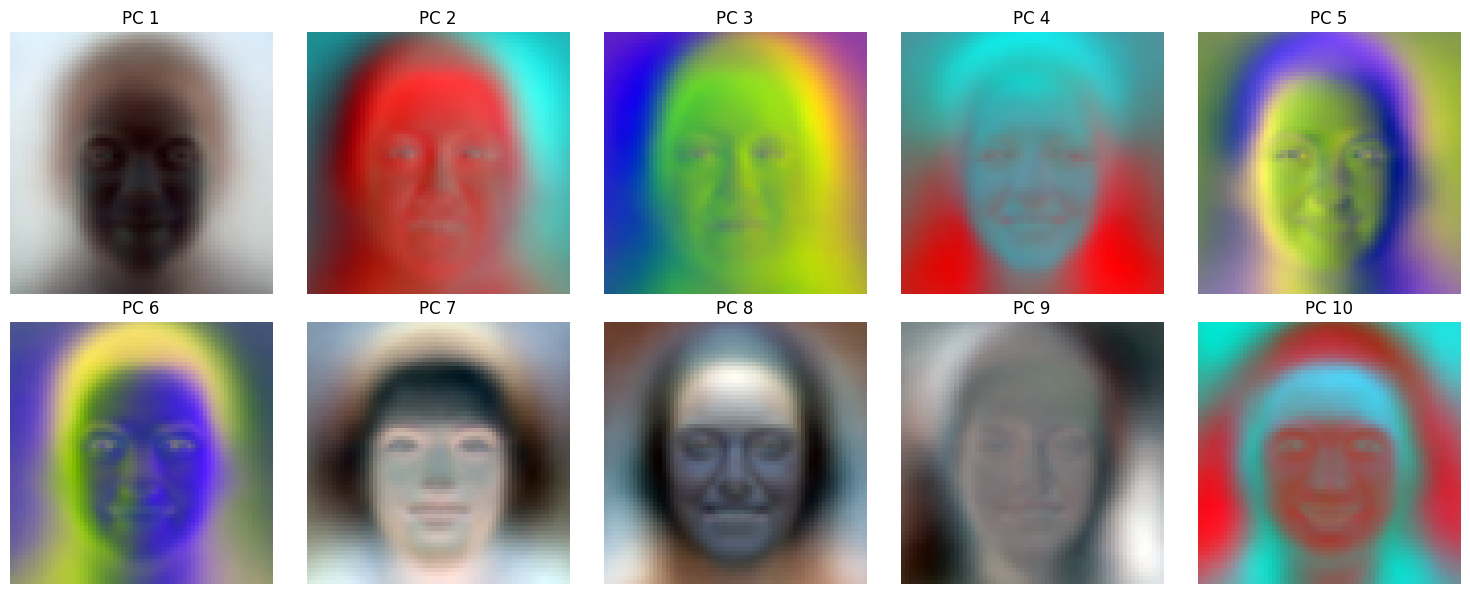

In [30]:
def minMaxNormalization(X):
    Xmin = X.min()
    Xmax = X.max()
    return ( X - Xmin ) / ( Xmax - Xmin )

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flat):
    ax.imshow(minMaxNormalization(pcs[i]))
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f"PC {i+1}")

plt.tight_layout()
plt.savefig("10-principals_sklearn.png")
plt.show()

In [ ]:

def normalizeMean(X):
    mean = X.mean(axis=0)
    return X - mean, mean

def covarianceMatrix(X):
    return np.cov(X, rowvar=False) / (X.shape[0]-1)

def findEigens(X):
    eigValues, eigVectors = np.linalg.eigh(X)
    sorted_indices = np.argsort(eigValues)[::-1]
    eigValues = eigValues[sorted_indices]
    eigVectors = eigVectors[:, sorted_indices]
    return eigValues, eigVectors

def calculatePrincipalComponentsForRGB(images):
    R = images[:, :, :, 0].reshape(images.shape[0], -1)
    G = images[:, :, :, 1].reshape(images.shape[0], -1)
    B = images[:, :, :, 2].reshape(images.shape[0], -1)

    eigValues, eigVectors, means = [], [], []

    for ch in [R, G, B]:
        ch, mean = normalizeMean(covarianceMatrix(ch))
        vals, vecs = findEigens(ch)
        eigValues.append(vals)
        eigVectors.append(vecs)
        means.append(mean)

    return np.array(eigValues), np.array(eigVectors), np.array(means)

def reshapeEigenvectors(eigVectors, mean, numComponents=10):
    eigVectors = eigVectors[:, :numComponents].T.reshape((numComponents, 64, 64)) + mean.reshape((64, 64))
    return minMaxNormalization(eigVectors)

def minMaxNormalization(X):
    Xmin = X.min()
    Xmax = X.max()
    return ( X - Xmin ) / ( Xmax - Xmin )

def centerImage(image, mean):
    return image.flatten() - mean

def findWeights(image, eigVectors, k, means):
    weights = []
    for ch in range(3):
        imageCh = centerImage(image[:,:,ch], means[ch])
        pcs = eigVectors[ch,:,:k]
        weights.append(np.dot(pcs.T, imageCh))
    return np.array(weights)

def reconstructImage(weights, eigVectors, means):
    image = []

    for ch in range(3):
        pcs = eigVectors[ch, :, :weights.shape[1]]
        reconstructed = means[ch] + pcs @ weights[ch]
        image.append(reconstructed.reshape(64,64))

    return np.stack(image, axis=-1)


In [3]:
eigValues, eigVectors, means = calculatePrincipalComponentsForRGB(images)

In [102]:
R = reshapeEigenvectors(eigVectors[0], means[0])
G = reshapeEigenvectors(eigVectors[1], means[1])
B = reshapeEigenvectors(eigVectors[2], means[2])

pcs = np.stack((R,G,B), axis=-1)

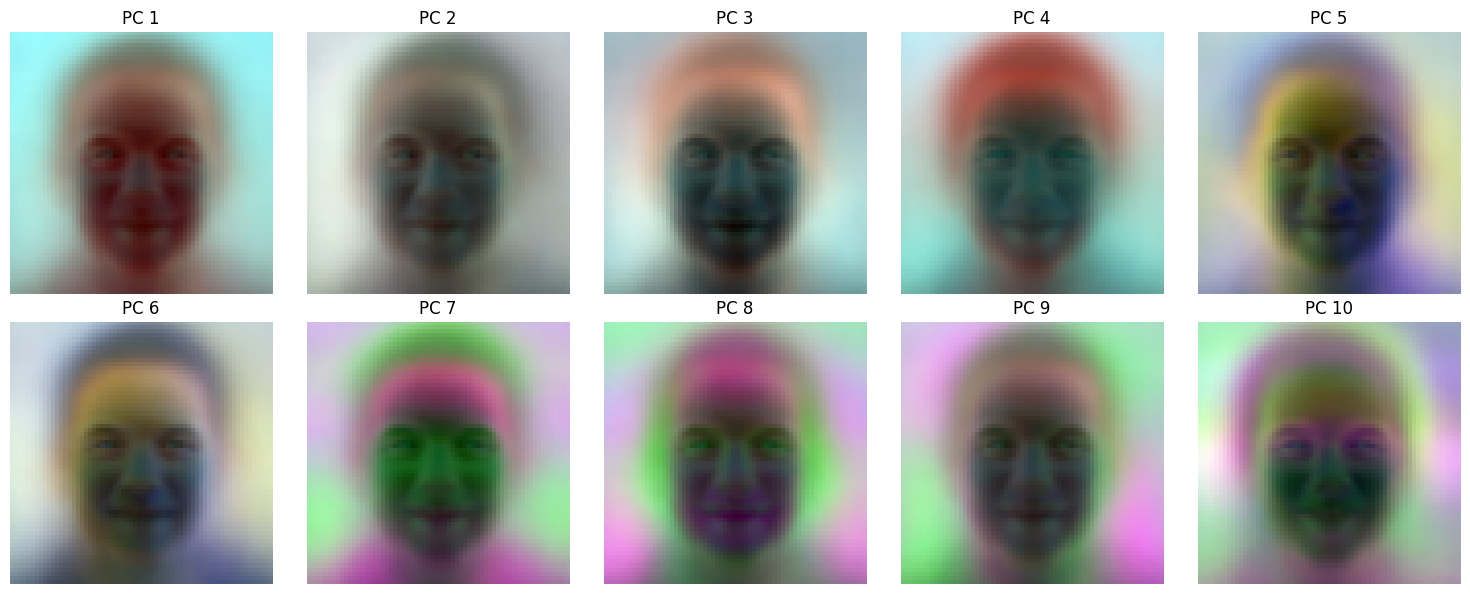

In [103]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flat):
    ax.imshow(pcs[i])
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f"PC {i+1}")

plt.tight_layout()
plt.savefig("10-principals.png")
plt.show()


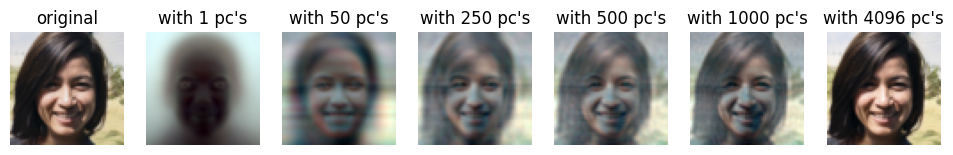

In [140]:
image = np.array(Image.open(IMAGES_FOLDER + 'image_9577.png')).astype(np.float32)

ks = [1,50,250,500,1000,4096]
fig, axes = plt.subplots(1, len(ks)+1, figsize=(12,2))

ax = axes[0]
ax.imshow(image / 256)
ax.axis('off')  # Turn off axis labels
ax.set_title("original")

for i,k in enumerate(ks):
    weights = findWeights(image, eigVectors, k, means)
    rcImage = reconstructImage(weights, eigVectors, means)
    ax = axes[i+1]
    ax.imshow(minMaxNormalization(rcImage))
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f"with {k} pc's")

plt.savefig('recreated.png')
plt.show()